# Section 1: Setup

In [20]:
# importing all the required libraries

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score, mean_absolute_error, mean_squared_error
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats

# Section 2: Data Acquisition

In [2]:
%%writefile kaggle.json
{"username":"sairamparshi07","key":"a07ce4e9f16b95b9b0c358f5b12deec7"}

Writing kaggle.json


In [3]:
# Step 1: Install the Kaggle library
!pip install -q kaggle

# Step 2: Upload the kaggle.json file
# from google.colab import files
# files.upload()

# Make sure the kaggle.json file is present
!ls -lha kaggle.json

# Step 3: Create a Kaggle directory and move the kaggle.json file into it
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Change the permission of the file
!chmod 600 ~/.kaggle/kaggle.json

# Step 4: Download the Sepsis Prediction dataset
!kaggle datasets download -d salikhussaini49/prediction-of-sepsis

# Step 5: Unzip the dataset and remove the zip file
!unzip -q prediction-of-sepsis.zip
!rm prediction-of-sepsis.zip


-rw-r--r-- 1 root root 71 Jan 17 04:23 kaggle.json
 94% 70.0M/74.7M [00:01<00:00, 85.9MB/s]
100% 74.7M/74.7M [00:01<00:00, 74.6MB/s]


In [4]:
# importing the file with the combined data of both the hospitals and splitting it into 2 parts

combined = pd.read_csv('/content/Dataset.csv')

# Splitting dataset into training and testing parts
rows_to_drop = combined.loc[combined['Patient_ID'].apply(lambda x: len(str(x)) == 6)]
df_train = combined.drop(rows_to_drop.index)
df_train.to_csv('data_part1.csv', index=False)

rows_to_drop = combined.loc[combined['Patient_ID'].apply(lambda x: len(str(x)) != 6)]
df_test = combined.drop(rows_to_drop.index)
df_test.to_csv('data_part2.csv', index=False)

In [5]:
# Loading the test and training data

df_train = pd.read_csv('/content/data_part1.csv')
df_test = pd.read_csv('/content/data_part2.csv')

# Section 3: Exploratory Data Analysis (EDA)

In [21]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790215 entries, 0 to 790214
Data columns (total 44 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        790215 non-null  int64  
 1   Hour              790215 non-null  int64  
 2   HR                729026 non-null  float64
 3   O2Sat             695136 non-null  float64
 4   Temp              266901 non-null  float64
 5   SBP               670014 non-null  float64
 6   MAP               709357 non-null  float64
 7   DBP               409918 non-null  float64
 8   Resp              712957 non-null  float64
 9   EtCO2             0 non-null       float64
 10  BaseExcess        82381 non-null   float64
 11  HCO3              63617 non-null   float64
 12  FiO2              112155 non-null  float64
 13  pH                90615 non-null   float64
 14  PaCO2             69288 non-null   float64
 15  SaO2              39160 non-null   float64
 16  AST               11

In [22]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 761995 entries, 0 to 761994
Data columns (total 44 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        761995 non-null  int64  
 1   Hour              761995 non-null  int64  
 2   HR                669785 non-null  float64
 3   O2Sat             654338 non-null  float64
 4   Temp              258325 non-null  float64
 5   SBP               655931 non-null  float64
 6   MAP               649583 non-null  float64
 7   DBP               655738 non-null  float64
 8   Resp              600918 non-null  float64
 9   EtCO2             57636 non-null   float64
 10  BaseExcess        1764 non-null    float64
 11  HCO3              1411 non-null    float64
 12  FiO2              17210 non-null   float64
 13  pH                16958 non-null   float64
 14  PaCO2             17013 non-null   float64
 15  SaO2              14401 non-null   float64
 16  AST               13

In [6]:
# Exploring the Training Dataset
print("First few rows of the training dataset:")
print(df_train.head())

# Dataset Shape and Basic Statistics
print("\nShape of the training dataset:", df_train.shape)
print("\nBasic statistical summary of the training dataset:")
print(df_train.describe())

# Checking for missing values in the training dataset
print("\nMissing values in each column of the training dataset:")
print(df_train.isnull().sum())

# Exploring the Testing Dataset
print("\nFirst few rows of the testing dataset:")
print(df_test.head())

# Dataset Shape and Basic Statistics
print("\nShape of the testing dataset:", df_test.shape)
print("\nBasic statistical summary of the testing dataset:")
print(df_test.describe())

# Checking for missing values in the testing dataset
print("\nMissing values in each column of the testing dataset:")
print(df_test.isnull().sum())

First few rows of the training dataset:
   Unnamed: 0  Hour    HR  O2Sat  Temp    SBP   MAP   DBP  Resp  EtCO2  ...  \
0           0     0   NaN    NaN   NaN    NaN   NaN   NaN   NaN    NaN  ...   
1           1     1  65.0  100.0   NaN    NaN  72.0   NaN  16.5    NaN  ...   
2           2     2  78.0  100.0   NaN    NaN  42.5   NaN   NaN    NaN  ...   
3           3     3  73.0  100.0   NaN    NaN   NaN   NaN  17.0    NaN  ...   
4           4     4  70.0  100.0   NaN  129.0  74.0  69.0  14.0    NaN  ...   

   Fibrinogen  Platelets    Age  Gender  Unit1  Unit2  HospAdmTime  ICULOS  \
0         NaN        NaN  68.54       0    NaN    NaN        -0.02       1   
1         NaN        NaN  68.54       0    NaN    NaN        -0.02       2   
2         NaN        NaN  68.54       0    NaN    NaN        -0.02       3   
3         NaN        NaN  68.54       0    NaN    NaN        -0.02       4   
4         NaN      330.0  68.54       0    NaN    NaN        -0.02       5   

   SepsisLabel  

In [7]:
# Display the first 15 rows of the dataframe
def display_first_15_rows(df):
    """Display the first 15 rows of the dataframe."""
    return df.head(15)

display_first_15_rows(df_train)

,Unnamed: 0,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,...,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID
0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,1,0,17072
1,1,1,65.0,100.0,NaN,NaN,72.0,NaN,16.5,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,2,0,17072
2,2,2,78.0,100.0,NaN,NaN,42.5,NaN,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,3,0,17072
3,3,3,73.0,100.0,NaN,NaN,NaN,NaN,17.0,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,4,0,17072
4,4,4,70.0,100.0,NaN,129.0,74.0,69.0,14.0,NaN,...,NaN,330.0,68.54,0,NaN,NaN,-0.02,5,0,17072
5,5,5,62.0,100.0,NaN,124.0,85.0,61.0,14.0,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,6,0,17072
6,6,6,61.0,100.0,NaN,101.0,75.0,58.0,14.0,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,7,0,17072
7,7,7,68.0,100.0,35.78,142.0,93.5,78.0,16.0,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,8,0,17072
8,8,8,71.0,100.0,NaN,121.0,74.0,91.0,14.0,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,9,0,17072
9,9,9,69.0,100.0,NaN,120.0,79.0,98.0,14.0,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,10,0,17072


In [8]:
# List all the columns in the dataframe
def list_columns(df):
    """List all the columns in the dataframe."""
    return df.columns

list_columns(df_train)

Index(['Unnamed: 0', 'Hour', 'HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP',
       'Resp', 'EtCO2', 'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2',
       'AST', 'BUN', 'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine',
       'Bilirubin_direct', 'Glucose', 'Lactate', 'Magnesium', 'Phosphate',
       'Potassium', 'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2',
       'HospAdmTime', 'ICULOS', 'SepsisLabel', 'Patient_ID'],
      dtype='object')

In [9]:
# List of unique patients and total number of patients in the dataset
def unique_patients_count(df):
    """List of unique patients and total number of patients in the dataset."""
    patients = list(df['Patient_ID'].unique())
    total_patients = len(patients)
    return patients, total_patients

unique_patients, total_patients = unique_patients_count(df_test)
print("Unique Patients:", unique_patients)
print("Total Number of Patients:", total_patients)

Unique Patients: [101097, 116819, 109105, 102538, 118465, 106286, 119524, 110099, 114420, 118912, 109208, 113395, 109925, 103055, 100463, 116209, 118692, 117889, 113606, 102715, 108942, 109156, 114040, 114240, 108984, 114571, 114869, 119597, 115618, 110014, 113809, 117631, 113818, 112328, 106903, 102446, 107437, 109162, 117302, 107199, 115603, 119727, 103661, 100119, 106045, 113108, 105431, 106707, 110299, 114908, 105506, 109489, 108085, 111520, 110753, 106598, 117662, 116431, 100544, 102636, 107862, 100165, 116948, 108119, 108462, 116167, 113059, 103246, 104545, 108212, 103231, 108066, 106777, 109122, 100849, 106631, 109716, 116670, 109385, 118375, 118431, 116029, 100764, 102736, 114213, 100181, 102587, 108947, 102245, 118945, 104574, 102316, 117298, 103905, 119982, 116452, 119854, 104063, 100744, 117033, 109170, 109428, 119682, 102244, 114547, 114685, 108860, 100687, 112041, 108741, 114698, 101658, 105325, 119535, 113634, 101326, 100507, 116934, 109336, 106794, 105315, 111433, 112670

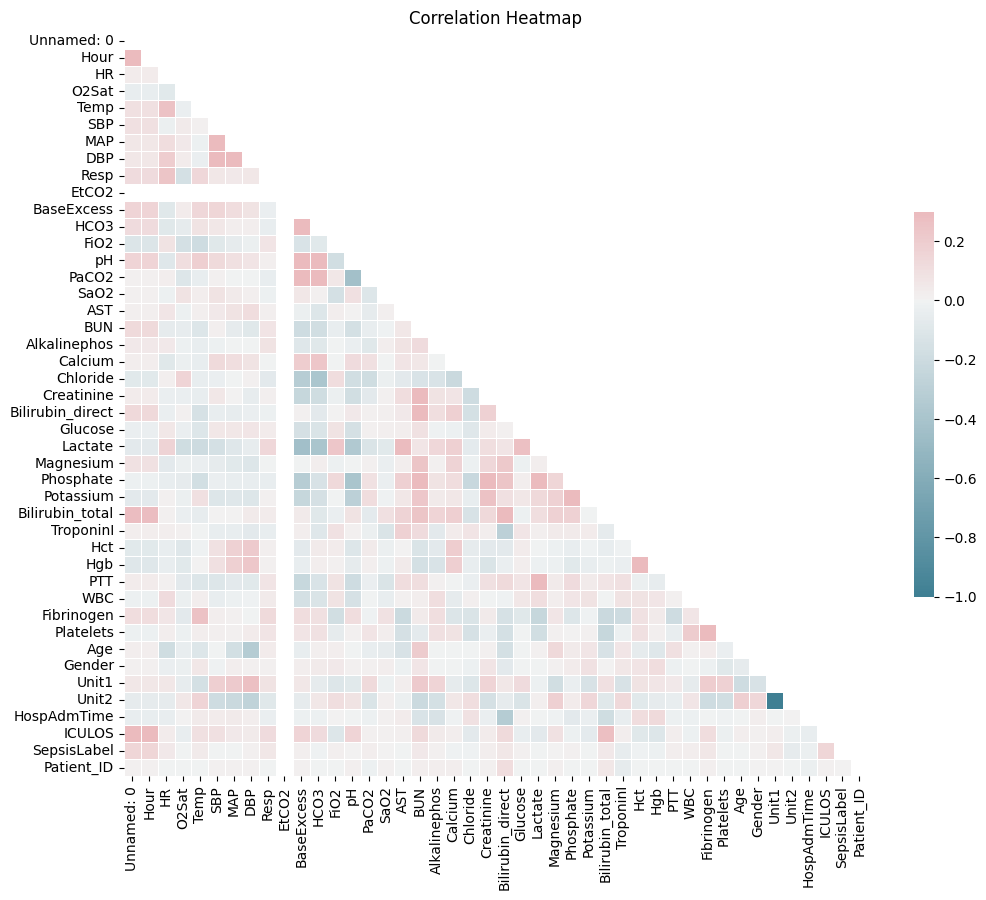

In [10]:
# Function to draw a correlation heatmap
def draw_correlation_heatmap(df):
    """Draw a correlation heatmap for the dataframe."""
    corr = df.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    f, ax = plt.subplots(figsize=(12, 10))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.title("Correlation Heatmap")

draw_correlation_heatmap(df_train)

In [11]:
# Percentage of null values present in all the parameters
def percentage_null_values(df):
    """Calculate the percentage of null values present in all parameters."""
    null_values = df.isnull().mean() * 100
    null_values = null_values.sort_values(ascending=False)
    return null_values

null_values_percentage = percentage_null_values(df_train)
print("Percentage of Null Values:")
print(null_values_percentage)

Percentage of Null Values:
EtCO2               100.000000
TroponinI            99.877881
Bilirubin_direct     99.850420
Fibrinogen           99.236917
Bilirubin_total      98.773372
Alkalinephos         98.540650
AST                  98.504205
Lactate              96.565112
PTT                  95.152459
SaO2                 95.044387
Calcium              95.024392
Phosphate            94.951247
Platelets            93.482913
Creatinine           93.357884
WBC                  92.489639
Magnesium            92.219712
HCO3                 91.949406
BUN                  91.840702
Chloride             91.676063
PaCO2                91.231753
Hgb                  91.164303
BaseExcess           89.574863
Potassium            89.137640
pH                   88.532868
Hct                  88.223711
Glucose              87.768392
FiO2                 85.807027
Temp                 66.224255
Unit1                48.868346
Unit2                48.868346
DBP                  48.125763
SBP         

# Section 4: Data Preprocessing


In [12]:
# Remove features with high null values and redundancy
def remove_redundant_features(df):
    """Remove features with high null values and redundancy."""
    columns_to_drop = {
        'Unnamed: 0', 'SBP', 'DBP', 'EtCO2', 'BaseExcess', 'HCO3', 'pH', 'PaCO2', 'Alkalinephos', 'Calcium', 'Magnesium',
        'Phosphate', 'Potassium', 'PTT', 'Fibrinogen', 'Unit1', 'Unit2'
    }
    # Merge Unit1 and Unit2 columns into a single 'Unit' column
    df = df.assign(Unit=df['Unit1'] + df['Unit2'])
    df_mod = df.drop(columns=columns_to_drop)
    return df_mod

df_train_modified = remove_redundant_features(df_train)
print("Columns after removing redundant features:")
print(df_train_modified.columns)


Columns after removing redundant features:
Index(['Hour', 'HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'FiO2', 'SaO2', 'AST',
       'BUN', 'Chloride', 'Creatinine', 'Bilirubin_direct', 'Glucose',
       'Lactate', 'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'WBC',
       'Platelets', 'Age', 'Gender', 'HospAdmTime', 'ICULOS', 'SepsisLabel',
       'Patient_ID', 'Unit'],
      dtype='object')


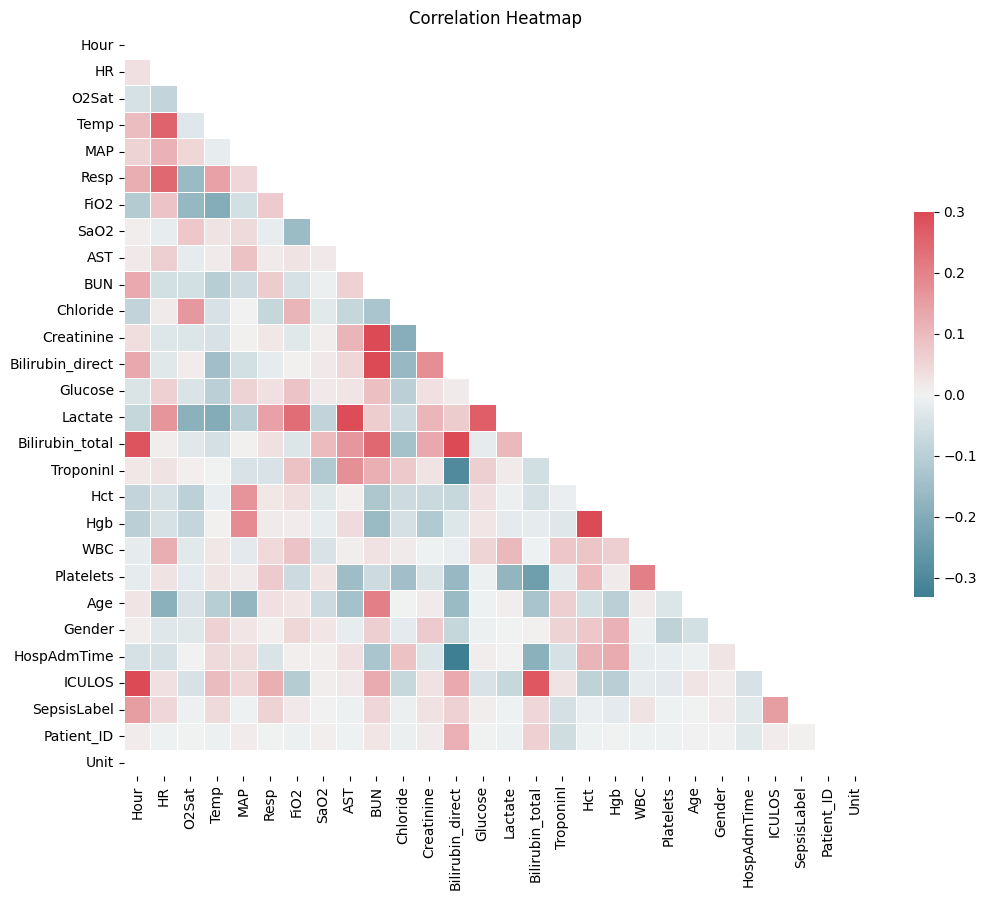

In [13]:
# Check correlation between remaining features
draw_correlation_heatmap(df_train_modified)

<ipython-input-14-dbe02de4384b>:17: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_imputed = grouped_by_patient.apply(lambda x: x.bfill().ffill())


Remaining Missing Values after Imputation:
Unnamed: 0            0.000000
Hour                  0.000000
HR                    0.001139
O2Sat                 0.026702
Temp                  0.853692
SBP                   1.261808
MAP                   0.003037
DBP                  32.667692
Resp                  0.088710
EtCO2               100.000000
BaseExcess           32.527224
HCO3                  1.299646
FiO2                 36.195592
pH                   29.956784
PaCO2                32.839037
SaO2                 57.282891
AST                  66.435590
BUN                   0.937719
Alkalinephos         67.334207
Calcium              13.871668
Chloride              1.310656
Creatinine            1.029467
Bilirubin_direct     96.256841
Glucose               0.940630
Lactate              55.997418
Magnesium             4.110527
Phosphate            13.199699
Potassium             1.020861
Bilirubin_total      66.949754
TroponinI            97.357934
Hct                   0.779

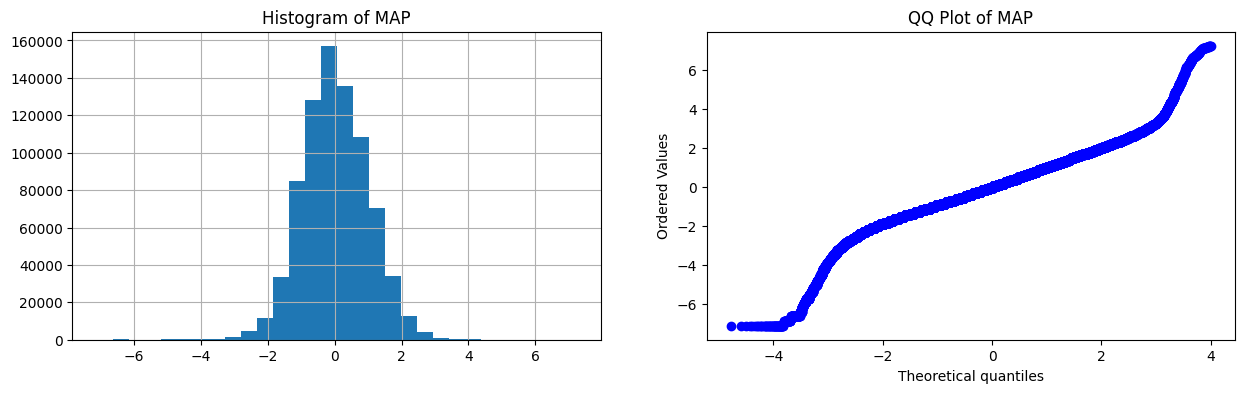

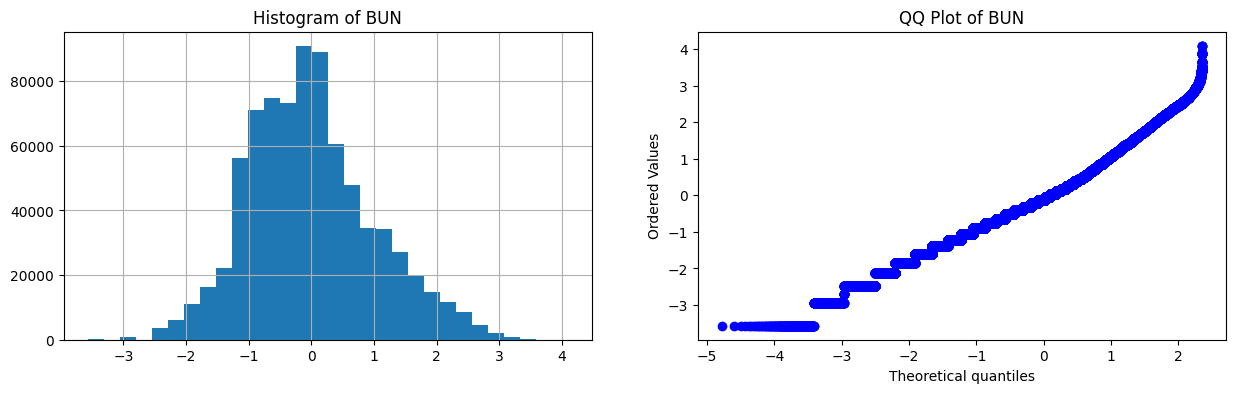

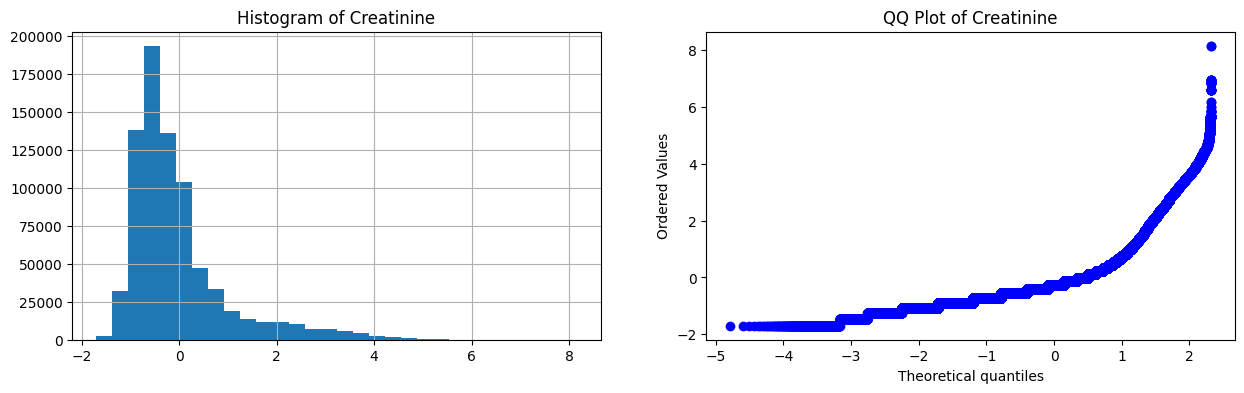

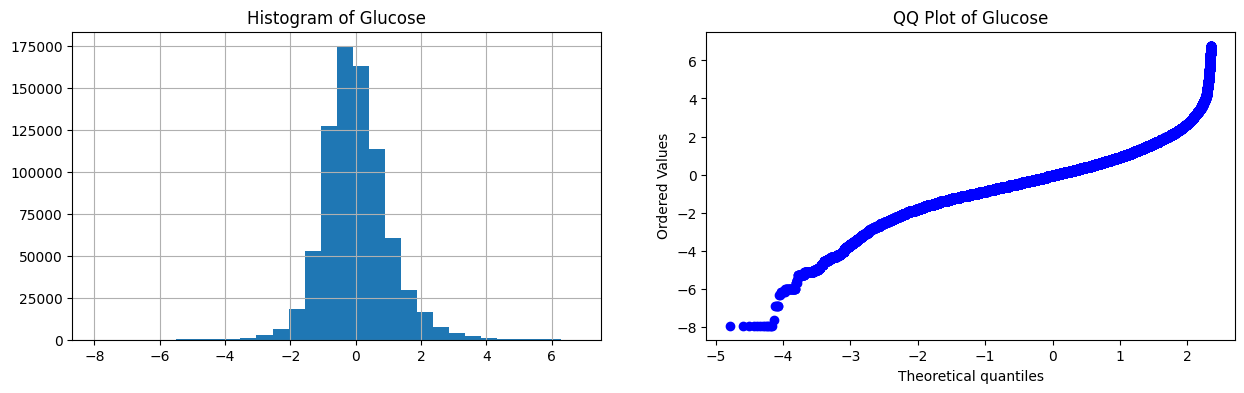

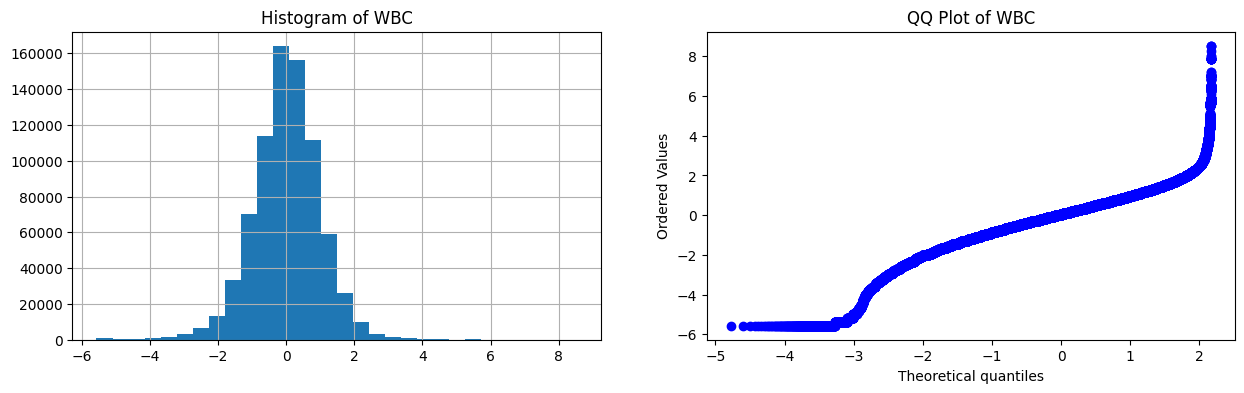

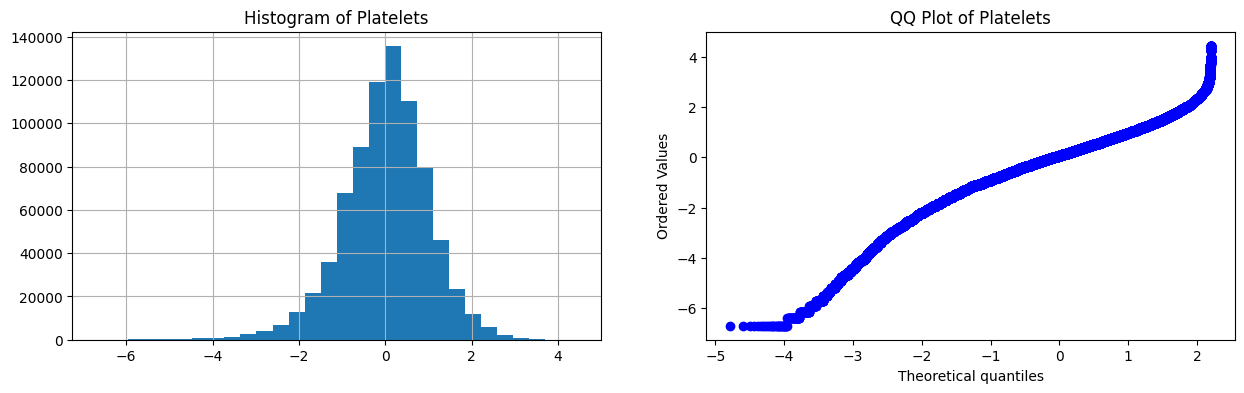

Processed Training Data:
   Unnamed: 0  Hour    HR  O2Sat   Temp    SBP       MAP  Resp  HCO3  \
0           0     0  65.0  100.0  35.78  129.0 -0.397650  16.5  26.0   
1           1     1  65.0  100.0  35.78  129.0 -0.397650  16.5  26.0   
2           2     2  78.0  100.0  35.78  129.0 -3.187955  17.0  26.0   
3           3     3  73.0  100.0  35.78  129.0 -0.251970  17.0  26.0   
4           4     4  70.0  100.0  35.78  129.0 -0.251970  14.0  26.0   

        BUN  ...  Hgb       WBC  Platelets    Age  HospAdmTime  ICULOS  \
0  0.322965  ...  9.5  0.149678   1.140763  68.54        -0.02       1   
1  0.322965  ...  9.5  0.149678   1.140763  68.54        -0.02       2   
2  0.322965  ...  9.5  0.149678   1.140763  68.54        -0.02       3   
3  0.322965  ...  9.5  0.149678   1.140763  68.54        -0.02       4   
4  0.322965  ...  9.5  0.149678   1.140763  68.54        -0.02       5   

   SepsisLabel  Patient_ID  Gender_0  Gender_1  
0            0       17072         1         0  

In [14]:
# Function to draw histogram and QQ plot
def diagnostic_plots(df, variable):
    fig = plt.figure(figsize=(15, 4))
    ax = fig.add_subplot(121)
    df[variable].hist(bins=30)
    ax.set_title(f'Histogram of {variable}')

    ax = fig.add_subplot(122)
    stats.probplot(df[variable], dist="norm", plot=plt)
    ax.set_title(f'QQ Plot of {variable}')

    plt.show()

# Function to impute missing values using forward fill and backward fill
def impute_missing_values(df):
    grouped_by_patient = df.groupby('Patient_ID')
    df_imputed = grouped_by_patient.apply(lambda x: x.bfill().ffill())
    return df_imputed

# Function to check and display the percentage of missing values
def check_missing_values(df):
    null_values_percentage = df.isnull().mean() * 100
    return null_values_percentage

# Function to drop columns with high missing values and columns that are not needed
def drop_high_missing_columns(df):
    columns_to_drop = [
        'EtCO2', 'TroponinI', 'Bilirubin_direct', 'Fibrinogen', 'Alkalinephos', 'Bilirubin_total',
        'AST', 'SaO2', 'Lactate', 'Unit2', 'Unit1', 'FiO2', 'PaCO2', 'DBP', 'BaseExcess', 'pH', 'PTT',
        'Calcium', 'Phosphate', 'Magnesium'
    ]
    df_cleaned = df.drop(columns=columns_to_drop)
    return df_cleaned

# Function to one-hot encode the 'Gender' column
def one_hot_encode_gender(df):
    df_encoded = pd.get_dummies(df, columns=['Gender'], prefix='Gender')
    return df_encoded

# Function to apply Gaussian Transformation and Standard Normalization to specified columns
def apply_gaussian_transformation_and_normalization(df, columns_to_transform):
    for column in columns_to_transform:
        # Log Transformation
        df[column] = np.log(df[column] + 1)
        # Standard Normalization
        scaler = StandardScaler()
        df[column] = scaler.fit_transform(df[[column]])
    return df

# Function to display diagnostic plots for specified columns
def display_diagnostic_plots(df, columns_to_transform):
    for column in columns_to_transform:
        diagnostic_plots(df, column)

# Preprocess the training dataset
def preprocess_data(df):
    df_imputed = impute_missing_values(df)
    null_values_percentage_imputed = check_missing_values(df_imputed)
    print("Remaining Missing Values after Imputation:")
    print(null_values_percentage_imputed)

    df_cleaned = drop_high_missing_columns(df_imputed)
    print("Columns after dropping high missing value columns:")
    print(df_cleaned.columns)

    df_encoded = one_hot_encode_gender(df_cleaned)

    columns_to_transform = ['MAP', 'BUN', 'Creatinine', 'Glucose', 'WBC', 'Platelets']
    df_processed = apply_gaussian_transformation_and_normalization(df_encoded, columns_to_transform)

    # Display diagnostic plots for specified columns
    display_diagnostic_plots(df_processed, columns_to_transform)

    return df_processed

# Preprocess the training dataset
df_train_preprocessed = preprocess_data(df_train)

# Display the processed training dataset
print("Processed Training Data:")
print(df_train_preprocessed.head())

In [15]:
check_missing_values(df_train_preprocessed)

Unnamed: 0     0.000000
Hour           0.000000
HR             0.001139
O2Sat          0.026702
Temp           0.853692
SBP            1.261808
MAP            0.003037
Resp           0.088710
HCO3           1.299646
BUN            0.937719
Chloride       1.310656
Creatinine     1.029467
Glucose        0.940630
Potassium      1.020861
Hct            0.779028
Hgb            1.158672
WBC            1.511994
Platelets      1.394810
Age            0.000000
HospAdmTime    0.001012
ICULOS         0.000000
SepsisLabel    0.000000
Patient_ID     0.000000
Gender_0       0.000000
Gender_1       0.000000
dtype: float64

In [16]:
df_train_preprocessed=df_train_preprocessed.dropna()

In [17]:
# prompt: df_train_preprocessed.cols()

df_train_preprocessed.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 755487 entries, 0 to 790214
Data columns (total 25 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Unnamed: 0   755487 non-null  int64  
 1   Hour         755487 non-null  int64  
 2   HR           755487 non-null  float64
 3   O2Sat        755487 non-null  float64
 4   Temp         755487 non-null  float64
 5   SBP          755487 non-null  float64
 6   MAP          755487 non-null  float64
 7   Resp         755487 non-null  float64
 8   HCO3         755487 non-null  float64
 9   BUN          755487 non-null  float64
 10  Chloride     755487 non-null  float64
 11  Creatinine   755487 non-null  float64
 12  Glucose      755487 non-null  float64
 13  Potassium    755487 non-null  float64
 14  Hct          755487 non-null  float64
 15  Hgb          755487 non-null  float64
 16  WBC          755487 non-null  float64
 17  Platelets    755487 non-null  float64
 18  Age          755487 non-

<ipython-input-14-dbe02de4384b>:17: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_imputed = grouped_by_patient.apply(lambda x: x.bfill().ffill())


Remaining Missing Values after Imputation:
Unnamed: 0           0.000000
Hour                 0.000000
HR                   0.017454
O2Sat                0.021391
Temp                 0.089764
SBP                  0.131891
MAP                  0.350921
DBP                  0.145014
Resp                 0.170342
EtCO2               79.505115
BaseExcess          96.047087
HCO3                97.069403
FiO2                64.772735
pH                  65.544656
PaCO2               65.379957
SaO2                68.889297
AST                 52.445095
BUN                  5.614473
Alkalinephos        52.420160
Calcium              5.530089
Chloride            90.114502
Creatinine           5.604630
Bilirubin_direct    90.165684
Glucose              4.542418
Lactate             71.348893
Magnesium           13.637229
Phosphate           36.257193
Potassium            5.200822
Bilirubin_total     52.384333
TroponinI           65.880616
Hct                  6.905295
Hgb                  6.8718

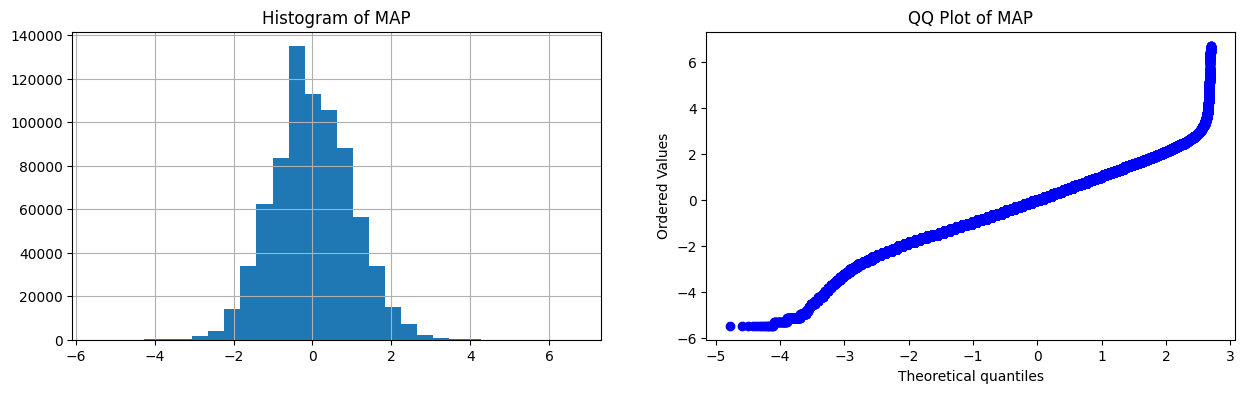

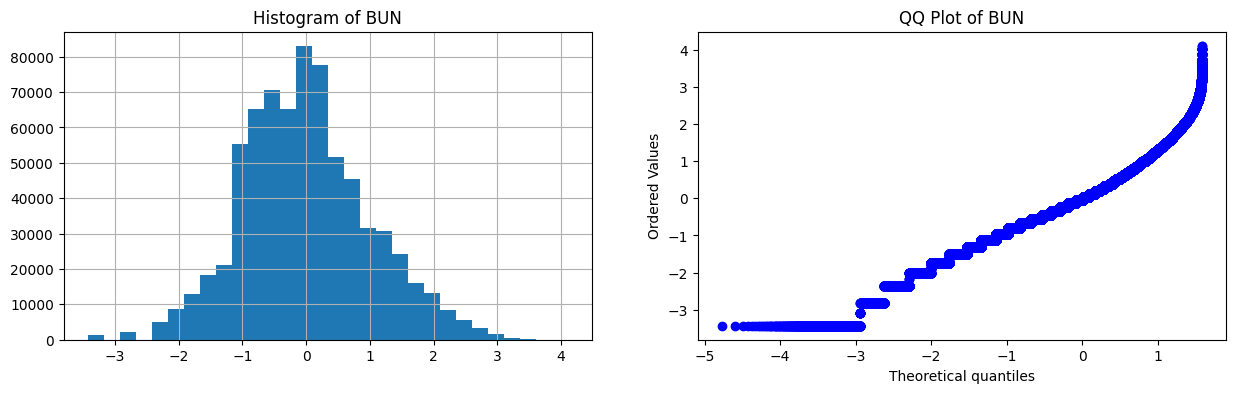

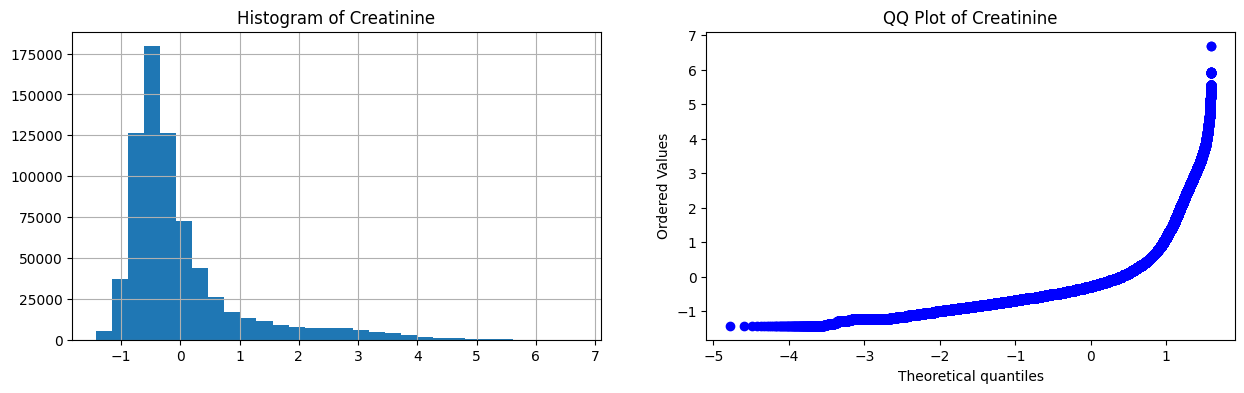

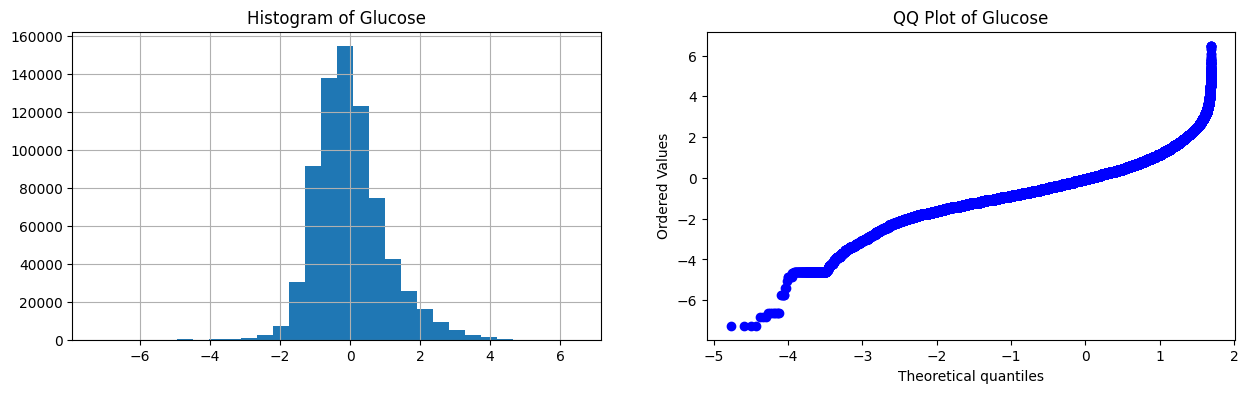

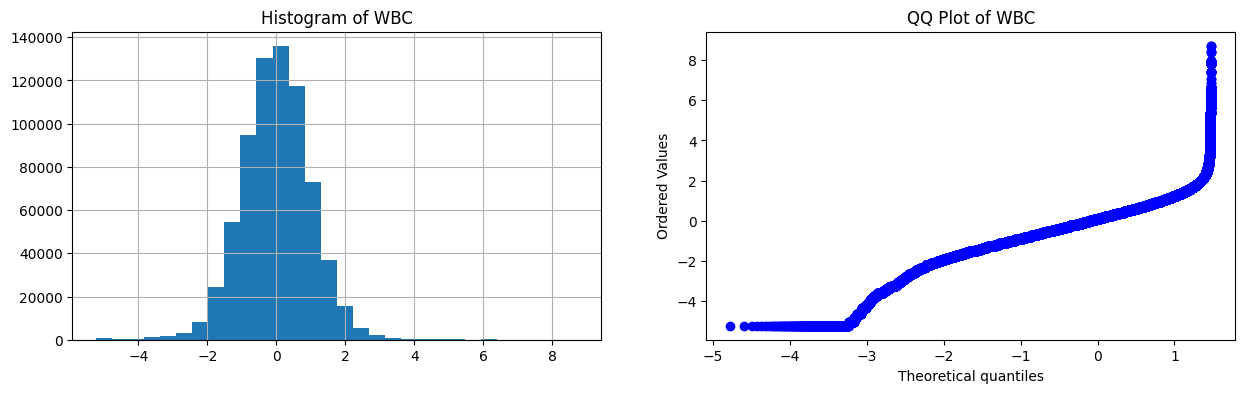

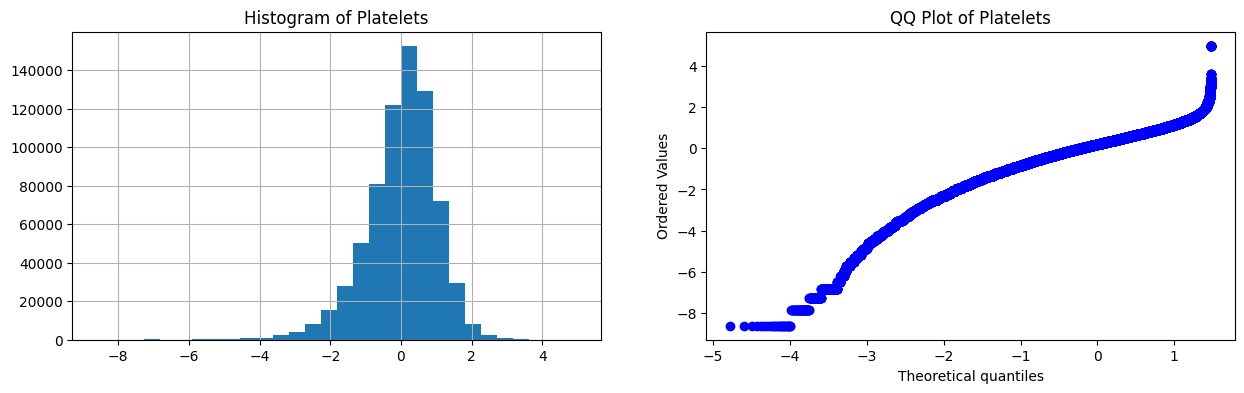

Processed testing Data:
   Unnamed: 0  Hour    HR  O2Sat  Temp    SBP       MAP  Resp  HCO3  BUN  ...  \
0           0     0  90.0  100.0  36.6  105.0 -0.674139  17.0   NaN  NaN  ...   
1           1     1  90.0  100.0  36.6  105.0 -0.674139  17.0   NaN  NaN  ...   
2           2     2  90.0  100.0  36.6  105.0 -0.674139  17.0   NaN  NaN  ...   
3           3     3  77.0  100.0  36.4  118.0 -0.137896  18.0   NaN  NaN  ...   
4           4     4  77.0  100.0  36.4  118.0 -0.137896  18.0   NaN  NaN  ...   

   Hgb  WBC  Platelets   Age  HospAdmTime  ICULOS  SepsisLabel  Patient_ID  \
0  NaN  NaN        NaN  63.0       -31.63       1            0      101097   
1  NaN  NaN        NaN  63.0       -31.63       2            0      101097   
2  NaN  NaN        NaN  63.0       -31.63       3            0      101097   
3  NaN  NaN        NaN  63.0       -31.63       4            0      101097   
4  NaN  NaN        NaN  63.0       -31.63       5            0      101097   

   Gender_0  Gender_

In [18]:
# Preprocess the testing dataset
df_test_preprocessed = preprocess_data(df_test)

# Display the processed testing dataset
print("Processed testing Data:")
print(df_test_preprocessed.head())

In [19]:
df_test_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 761995 entries, 0 to 761994
Data columns (total 25 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Unnamed: 0   761995 non-null  int64  
 1   Hour         761995 non-null  int64  
 2   HR           761862 non-null  float64
 3   O2Sat        761832 non-null  float64
 4   Temp         761311 non-null  float64
 5   SBP          760990 non-null  float64
 6   MAP          759321 non-null  float64
 7   Resp         760697 non-null  float64
 8   HCO3         22331 non-null   float64
 9   BUN          719213 non-null  float64
 10  Chloride     75327 non-null   float64
 11  Creatinine   719288 non-null  float64
 12  Glucose      727382 non-null  float64
 13  Potassium    722365 non-null  float64
 14  Hct          709377 non-null  float64
 15  Hgb          709632 non-null  float64
 16  WBC          708324 non-null  float64
 17  Platelets    708591 non-null  float64
 18  Age          761995 non-

In [23]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

def _preprocess_df(df):
    """
    Preprocess the given dataframe to make it compatible for model input.

    Steps:
    1. Remove redundant columns.
    2. Impute missing values using forward and backward fill.
    3. Drop columns with a high percentage of missing values.
    4. Apply Gaussian transformation on selected columns.
    5. Normalize the data.
    6. One-hot encode the gender column.

    Parameters:
    df (DataFrame): The dataframe to be preprocessed.

    Returns:
    DataFrame: The preprocessed dataframe.
    """
    # Define columns to be dropped due to redundancy
    columns_drop = {
        'Unnamed: 0', 'SBP', 'DBP', 'EtCO2', 'BaseExcess', 'HCO3', 'pH', 'PaCO2', 'Alkalinephos',
        'Calcium', 'Magnesium', 'Phosphate', 'Potassium', 'PTT', 'Fibrinogen', 'Unit1', 'Unit2'
    }

    # Merge Unit1 and Unit2 into a single column
    df = df.assign(Unit=df['Unit1'] + df['Unit2'])

    # Drop redundant columns
    df = df.drop(columns=columns_drop)

    # Impute missing values within each patient group
    grouped_by_patient = df.groupby('Patient_ID')
    df = grouped_by_patient.apply(lambda x: x.bfill().ffill())

    # Drop columns with more than 25% missing values and the patient ID
    null_col = ['TroponinI', 'Bilirubin_direct', 'AST', 'Bilirubin_total', 'Lactate', 'SaO2', 'FiO2', 'Unit', 'Patient_ID']
    df = df.drop(columns=null_col)

    # Apply Gaussian transformation (logarithmic) to selected columns
    columns_normalized = ['MAP', 'BUN', 'Creatinine', 'Glucose', 'WBC', 'Platelets']
    for column in columns_normalized:
        df[column] = np.log(df[column] + 1)

    # Normalize selected columns
    scaler = StandardScaler()
    columns_to_scale = ['HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'BUN', 'Chloride', 'Creatinine', 'Glucose', 'Hct', 'Hgb', 'WBC', 'Platelets']
    df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

    # One-hot encode the gender column
    one_hot = pd.get_dummies(df['Gender'])
    df = df.join(one_hot).drop('Gender', axis=1)

    # Drop rows with any remaining missing values
    df = df.dropna()

    return df


In [24]:
# Preprocess the training dataset
_df_train_preprocessed = _preprocess_df(df_train)

# Display the processed training dataset
print("Processed Training Data:")
print(_df_train_preprocessed.head())

<ipython-input-23-2d3d3c1b4099>:13: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df = grouped_by_patient.apply(lambda x: x.bfill().ffill())


Processed Training Data:
   Hour        HR     O2Sat      Temp       MAP      Resp       BUN  Chloride  \
0     0 -1.170030  0.865243 -1.548869 -0.397650 -0.419685  0.322965 -0.226541   
1     1 -1.170030  0.865243 -1.548869 -0.397650 -0.419685  0.322965 -0.226541   
2     2 -0.407913  0.865243 -1.548869 -3.187955 -0.326969  0.322965 -0.226541   
3     3 -0.701035  0.865243 -1.548869 -0.251970 -0.326969  0.322965 -0.226541   
4     4 -0.876908  0.865243 -1.548869 -0.251970 -0.883265  0.322965 -0.226541   

   Creatinine   Glucose       Hct       Hgb       WBC  Platelets    Age  \
0   -0.410796  0.854631 -0.311111 -0.652538  0.149678   1.140763  68.54   
1   -0.410796  0.854631 -0.311111 -0.652538  0.149678   1.140763  68.54   
2   -0.410796  0.854631 -0.311111 -0.652538  0.149678   1.140763  68.54   
3   -0.410796  0.854631 -0.311111 -0.652538  0.149678   1.140763  68.54   
4   -0.410796  0.854631 -0.311111 -0.652538  0.149678   1.140763  68.54   

   HospAdmTime  ICULOS  SepsisLabel  

In [36]:
# checking the distribution of data points between the two classes

majority_class = _df_train_preprocessed[_df_train_preprocessed['SepsisLabel'] == 0]
minority_class = _df_train_preprocessed[_df_train_preprocessed['SepsisLabel'] == 1]
print('number of sepsis label 1 is {}'.format(len(minority_class)))
print('while number of sepsis label 0 is {}'.format(len(majority_class)))

number of sepsis label 1 is 15284
while number of sepsis label 0 is 750935


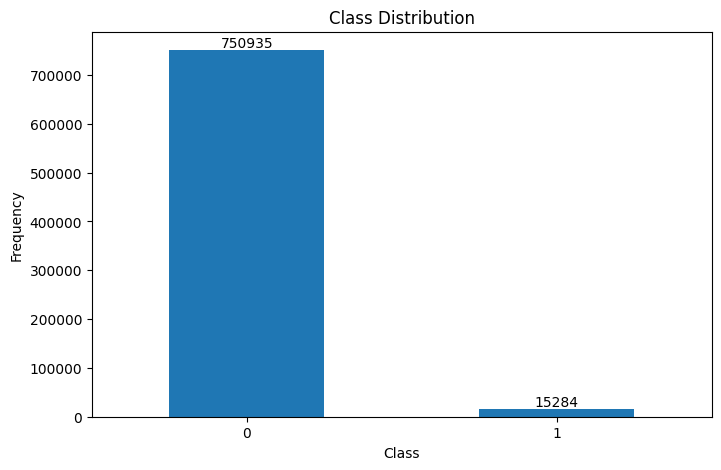

Number of instances for class 0: 750935
Number of instances for class 1: 15284


In [37]:
import matplotlib.pyplot as plt

def plot_class_distribution(df, target_column):
    """
    Plot the distribution of data points for different classes in the target column.

    Parameters:
    df (DataFrame): The DataFrame containing the target column.
    target_column (str): The name of the target column to analyze.
    """
    # Count the instances of each class
    class_counts = df[target_column].value_counts()

    # Create a bar plot
    plt.figure(figsize=(8, 5))
    class_counts.plot(kind='bar')
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.xticks(rotation=0)

    # Show the counts above the bars
    for index, value in enumerate(class_counts):
        plt.text(index, value, str(value), ha='center', va='bottom')

    # Display the plot
    plt.show()

    # Print the number of instances for each class
    for class_label, count in class_counts.items():
        print(f'Number of instances for class {class_label}: {count}')

# Example usage
plot_class_distribution(_df_train_preprocessed, 'SepsisLabel')


In [38]:
def undersample_dataframe(df, target_column, ratio=2):
    """
    Perform undersampling on a DataFrame to balance the class distribution.

    Parameters:
    df (DataFrame): The DataFrame to undersample.
    target_column (str): The name of the target column.
    ratio (int): The ratio of the number of majority class instances to minority class instances after undersampling.

    Returns:
    DataFrame: An undersampled DataFrame.
    """
    # Separating the majority and minority classes
    majority_class = df[df[target_column] == 0]
    minority_class = df[df[target_column] == 1]

    # Undersampling the majority class
    majority_class_subset = majority_class.sample(n=ratio * len(minority_class))

    # Concatenating the majority subset with the minority class
    undersampled_df = pd.concat([majority_class_subset, minority_class])

    return undersampled_df



In [39]:
_df_train_preprocessed = undersample_dataframe(_df_train_preprocessed, 'SepsisLabel')

# Section 5: Feature Selection Engineering with XGBoost

In [40]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load the preprocessed dataset
X = _df_train_preprocessed.drop('SepsisLabel', axis=1)
y = _df_train_preprocessed['SepsisLabel']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Convert column names to strings to avoid TypeError in scikit-learn
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)






<Figure size 1000x800 with 0 Axes>

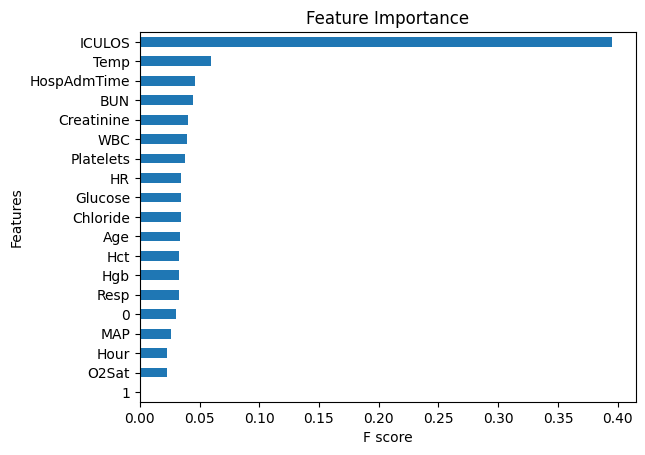

Selected features: Index([     'ICULOS',        'Temp', 'HospAdmTime',         'BUN',
        'Creatinine',         'WBC',   'Platelets',          'HR',
           'Glucose',    'Chloride',         'Age',         'Hct',
               'Hgb',        'Resp',             0,         'MAP',
              'Hour',       'O2Sat',             1],
      dtype='object')


In [41]:
# Standardize/Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled arrays back to DataFrame to retain column names
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns)

# Feature Selection using XGBoost
model = xgb.XGBClassifier()
model.fit(X_train_scaled_df, y_train)

# Get feature importances and convert to DataFrame
feature_importances_df = pd.DataFrame(model.feature_importances_, index=X.columns, columns=['importance']).sort_values('importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 8))
feature_importances_df.sort_values(by='importance', ascending=True).plot(kind='barh', legend=False)
plt.title('Feature Importance')
plt.xlabel('F score')
plt.ylabel('Features')
plt.show()

# Select top N important features
top_n_features = 20
top_features = feature_importances_df.index[:top_n_features]

# Create new DataFrame with selected features for model training
X_train_selected = X_train_scaled_df[top_features]
X_test_selected = X_test_scaled_df[top_features]

# Output selected feature names
print("Selected features:", top_features)

# Section 6: Model Development

In [42]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    mean_absolute_error,
    mean_squared_error,
    confusion_matrix
)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(y_true, y_pred):
    """
    Calculate and print different evaluation metrics of the model.

    Parameters:
    y_true (array-like): True labels.
    y_pred (array-like): Predicted labels by the model.

    Returns:
    None
    """
    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print("Accuracy:", accuracy)

    # Calculate precision
    precision = precision_score(y_true, y_pred)
    print("Precision:", precision)

    # Calculate recall
    recall = recall_score(y_true, y_pred)
    print("Recall:", recall)

    # Calculate F1 score
    f1 = f1_score(y_true, y_pred)
    print("F1 Score:", f1)

    # Calculate Area Under the Receiver Operating Characteristic Curve (ROC AUC)
    auc = roc_auc_score(y_true, y_pred)
    print("AUC-ROC:", auc)

    # Calculate Mean Absolute Error
    mae = mean_absolute_error(y_true, y_pred)
    print("Mean Absolute Error:", mae)

    # Calculate Root Mean Squared Error
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print("Root Mean Squared Error:", rmse)

    # Generate and plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.show()


In [43]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36681 entries, 598867 to 452550
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Hour         36681 non-null  int64  
 1   HR           36681 non-null  float64
 2   O2Sat        36681 non-null  float64
 3   Temp         36681 non-null  float64
 4   MAP          36681 non-null  float64
 5   Resp         36681 non-null  float64
 6   BUN          36681 non-null  float64
 7   Chloride     36681 non-null  float64
 8   Creatinine   36681 non-null  float64
 9   Glucose      36681 non-null  float64
 10  Hct          36681 non-null  float64
 11  Hgb          36681 non-null  float64
 12  WBC          36681 non-null  float64
 13  Platelets    36681 non-null  float64
 14  Age          36681 non-null  float64
 15  HospAdmTime  36681 non-null  float64
 16  ICULOS       36681 non-null  int64  
 17  0            36681 non-null  uint8  
 18  1            36681 non-null  uint8  
dty

SVM Model Evaluation:
Accuracy: 0.7485552284374659
Precision: 0.7926136363636364
Recall: 0.35654952076677315
F1 Score: 0.4918466284706919
AUC-ROC: 0.6541065763079024
Mean Absolute Error: 0.2514447715625341
Root Mean Squared Error: 0.5014426902074993


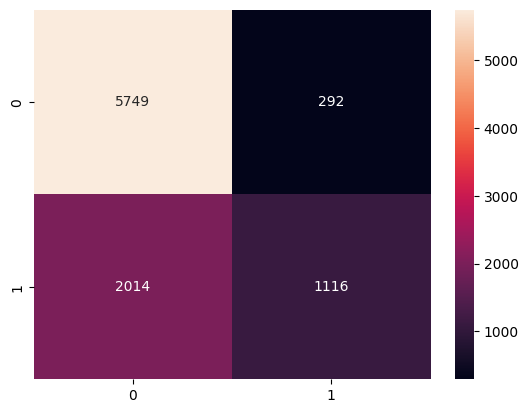

In [45]:
# Model: Support Vector Machine
from sklearn.svm import SVC

svm_model = SVC()
svm_model.fit(X_train, y_train)

# Predict on the test set
svm_y_pred = svm_model.predict(X_test)

# Evaluate the SVM model
print("SVM Model Evaluation:")
evaluate_model(y_test, svm_y_pred)

RandomForestClassifier Model Evaluation:
Accuracy: 0.9563842547159525
Precision: 0.9197416974169742
Recall: 0.955591054313099
F1 Score: 0.9373237229708555
AUC-ROC: 0.9561931434452434
Mean Absolute Error: 0.04361574528404754
Root Mean Squared Error: 0.20884382989221287


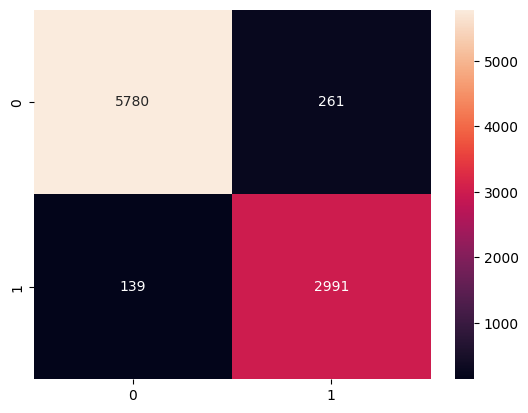

In [46]:
# Model: Random Forest Classifier

rfc_model = RandomForestClassifier(n_estimators=300, random_state=0)
rfc_model.fit(X_train, y_train)

# Predict on the test set
rcf_y_pred = model.predict(X_test)

# Evaluate the RandomForestClassifier model
print("RandomForestClassifier Model Evaluation:")
evaluate_model(y_test, rcf_y_pred)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [09:28:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.857812670374005
Precision: 0.8336988304093568
Recall: 0.7287539936102236
F1 Score: 0.7777020115922264
AUC-ROC: 0.8267176688792717
Mean Absolute Error: 0.14218732962599498
Root Mean Squared Error: 0.3770773523111604


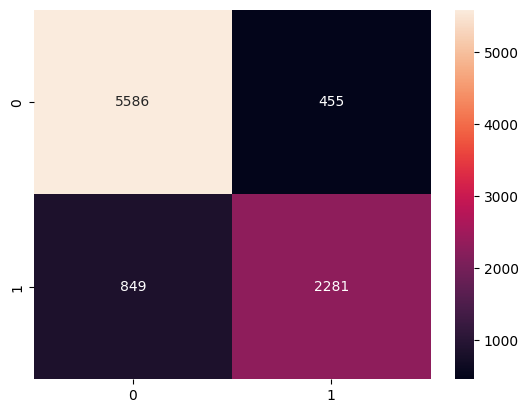

In [48]:
# Model: XGBoost

import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, mean_absolute_error, mean_squared_error, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def train_xgboost(X_train, y_train, params, num_rounds):
    """
    Train an XGBoost model with the given parameters.

    Parameters:
    X_train (DataFrame): Training features.
    y_train (Series): Training target variable.
    params (dict): Parameters for the XGBoost model.
    num_rounds (int): Number of boosting rounds.

    Returns:
    Booster: Trained XGBoost model.
    """
    dtrain = xgb.DMatrix(X_train, label=y_train)
    model = xgb.train(params, dtrain, num_rounds)
    return model

def predict_xgboost(model, X_test):
    """
    Make predictions using the trained XGBoost model.

    Parameters:
    model (Booster): Trained XGBoost model.
    X_test (DataFrame): Testing features.

    Returns:
    list: Predictions for the test set.
    """
    dtest = xgb.DMatrix(X_test)
    predictions = model.predict(dtest)
    return [1 if pred >= 0.5 else 0 for pred in predictions]

# XGBoost parameters
xgb_params = {
    'max_depth': 5,
    'eta': 0.3,
    'silent': 1,
    'objective': 'binary:logistic'
}
num_boost_rounds = 100

# Train and predict with XGBoost
xgb_model = train_xgboost(X_train, y_train, xgb_params, num_boost_rounds)
xgb_predictions = predict_xgboost(xgb_model, X_test)

# Evaluate the model
evaluate_model(y_test, xgb_predictions)


# Section 7: Model Evaluation on Test Data

In [49]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 761995 entries, 0 to 761994
Data columns (total 44 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        761995 non-null  int64  
 1   Hour              761995 non-null  int64  
 2   HR                669785 non-null  float64
 3   O2Sat             654338 non-null  float64
 4   Temp              258325 non-null  float64
 5   SBP               655931 non-null  float64
 6   MAP               649583 non-null  float64
 7   DBP               655738 non-null  float64
 8   Resp              600918 non-null  float64
 9   EtCO2             57636 non-null   float64
 10  BaseExcess        1764 non-null    float64
 11  HCO3              1411 non-null    float64
 12  FiO2              17210 non-null   float64
 13  pH                16958 non-null   float64
 14  PaCO2             17013 non-null   float64
 15  SaO2              14401 non-null   float64
 16  AST               13

In [51]:
df_test_preprocessed = _preprocess_df(df_test)

<ipython-input-23-2d3d3c1b4099>:13: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df = grouped_by_patient.apply(lambda x: x.bfill().ffill())


In [53]:
# Test df info after pre-processing
df_test_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74307 entries, 1052 to 761840
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Hour         74307 non-null  int64  
 1   HR           74307 non-null  float64
 2   O2Sat        74307 non-null  float64
 3   Temp         74307 non-null  float64
 4   MAP          74307 non-null  float64
 5   Resp         74307 non-null  float64
 6   BUN          74307 non-null  float64
 7   Chloride     74307 non-null  float64
 8   Creatinine   74307 non-null  float64
 9   Glucose      74307 non-null  float64
 10  Hct          74307 non-null  float64
 11  Hgb          74307 non-null  float64
 12  WBC          74307 non-null  float64
 13  Platelets    74307 non-null  float64
 14  Age          74307 non-null  float64
 15  HospAdmTime  74307 non-null  float64
 16  ICULOS       74307 non-null  int64  
 17  SepsisLabel  74307 non-null  int64  
 18  0            74307 non-null  uint8  
 19  

In [54]:
X = df_test_preprocessed.drop('SepsisLabel', axis=1)
y = df_test_preprocessed['SepsisLabel']

# Convert column names to strings to avoid TypeError in scikit-learn
X.columns = X.columns.astype(str)

SVM Model Evaluation:
Accuracy: 0.8886780518659076
Precision: 0.09886897953996696
Recall: 0.39714139867279225
F1 Score: 0.15832315832315833
AUC-ROC: 0.6495645070435891
Mean Absolute Error: 0.11132194813409235
Root Mean Squared Error: 0.333649438983632


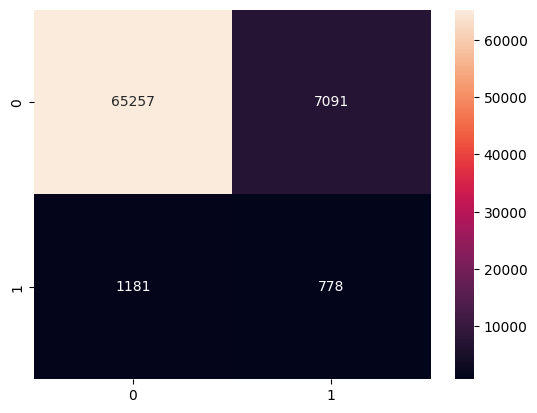

In [55]:
# Testing on SVM Model

svm_y_pred = svm_model.predict(X)

# Evaluate the SVM model
print("SVM Model Evaluation:")
evaluate_model(y, svm_y_pred)

Accuracy: 0.8576042633937583
Precision: 0.08571977705170095
Recall: 0.4553343542623788
F1 Score: 0.1442782046097857
AUC-ROC: 0.6619155323034125
Mean Absolute Error: 0.14239573660624166
Root Mean Squared Error: 0.3773535962545496


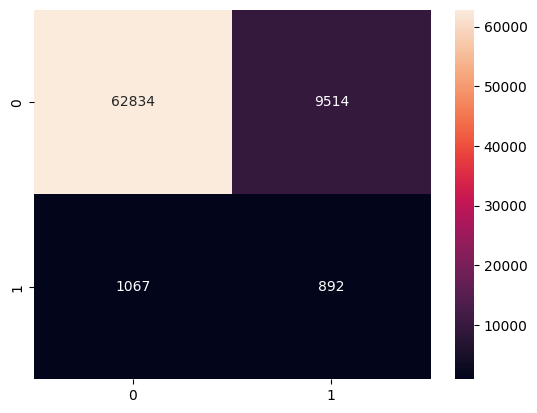

In [56]:
# Testing on XGBoost Model

xgb_y_pred = predict_xgboost(xgb_model, X)

# Evaluate the model
evaluate_model(y, xgb_y_pred)